# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

In [2]:
import numpy as np
import os
from imageio.v2 import imread
from skimage.transform import resize
import datetime
import os
import pathlib
import matplotlib.pyplot as plt
from sys import getsizeof

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras

import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!unzip -q /content/gdrive/MyDrive/Project_data.zip -d /content/Project_data/

In [6]:
train_doc = np.random.permutation(open('/content/Project_data/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/content/Project_data/Project_data/val.csv').readlines())


In [7]:
train_path = pathlib.Path("/content/Project_data/Project_data/train")
val_path = pathlib.Path("/content/Project_data/Project_data/val")

In [8]:
batch_size = 64 
dim_x = 80
dim_y = 80
img_idx = [2,4,6,8,10,12,14,16,18,20,22,24,26]

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [9]:
def generator(source_path, folder_list, batch_size,dim_x,dim_y,img_idx):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    x = len(img_idx)
    y,z = dim_x, dim_y
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(str(source_path)+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(str(source_path)+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    image = resize(image,(y,z)).astype(np.float32)
                    
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(t) % batch_size != 0:
            batch_data = np.zeros((batch_size,x,y,z,3)) 
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(str(source_path)+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(str(source_path)+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image = resize(image,(y,z)).astype(np.float32)
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1 
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield does    


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
#To keep time stamp in the names of models tried so that they are not overwritten with each new model
curr_dt_time = datetime.datetime.now()
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model Building
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D,TimeDistributed,Conv2D,MaxPooling2D,LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

In [ ]:
def plot(history):
 plt.figure(figsize=(20,6))
 ax1 = plt.subplot(121)
 ax1 = plt.plot(history.history['loss'])
 ax1 = plt.plot(history.history['val_loss'])
 plt.title('model loss')
 plt.ylabel('loss')
 plt.xlabel('epoch')
 plt.legend(['train', 'validation'], loc='lower left')
 ax2 = plt.subplot(122)
 ax2 = plt.plot(history.history['categorical_accuracy'])
 ax2 = plt.plot(history.history['val_categorical_accuracy'])
 plt.title('model accuracy')
 plt.ylabel('categorical_accuracy')
 plt.xlabel('epoch')
 plt.legend(['train', 'validation'], loc='lower left')

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [ ]:
def train_model():
        
    model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
#Save model(weights and parameters) after every epoch    
    if not os.path.exists(model_name):
        os.mkdir(model_name)
        
    filepath = model_name + "model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5"

    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',period = 1)

#When val loss plateaus i.e. gradient not moving towards minima, it is time to reduce learning rate.
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5) 
    callbacks_list = [checkpoint, LR]
    
    if (num_train_sequences%batch_size) == 0:
        steps_per_epoch = int(num_train_sequences/batch_size)
    else:
        steps_per_epoch = (num_train_sequences//batch_size) + 1

    if (num_val_sequences%batch_size) == 0:
        validation_steps = int(num_val_sequences/batch_size)
    else:
        validation_steps = (num_val_sequences//batch_size) + 1
    return callbacks_list, steps_per_epoch, validation_steps
    

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,dim_x,dim_y,img_idx)
val_generator = generator(val_path, val_doc, batch_size,dim_x,dim_y,img_idx)

 #  **MODEL 1**

In [ ]:
callbacks_list,steps_per_epoch, validation_steps = train_model()

In [ ]:
#New Model 1
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(len(img_idx),dim_x,dim_y,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [ ]:
optimiser = 'sgd' 
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 13, 80, 80, 32)    2624      
                                                                 
 activation (Activation)     (None, 13, 80, 80, 32)    0         
                                                                 
 batch_normalization (BatchN  (None, 13, 80, 80, 32)   128       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 40, 40, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 40, 40, 64)     16448     
                                                                 
 activation_1 (Activation)   (None, 6, 40, 40, 64)     0

In [ ]:
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition/Project_data/train ; batch size = 64
Epoch 1/20
11/11 [==============================] - ETA: 0s - loss: 1.8685 - categorical_accuracy: 0.3509 Source path =  /kaggle/input/gesture-recognition/Project_data/val ; batch size = 64

Epoch 1: saving model to model_init_2023-04-1610_05_15.639980/model-00001-1.86854-0.35085-1.57839-0.23438.h5
11/11 [==============================] - 141s 13s/step - loss: 1.8685 - categorical_accuracy: 0.3509 - val_loss: 1.5784 - val_categorical_accuracy: 0.2344 - lr: 0.0100
Epoch 2/20
11/11 [==============================] - ETA: 0s - loss: 1.2768 - categorical_accuracy: 0.5114
Epoch 2: saving model to model_init_2023-04-1610_05_15.639980/model-00002-1.27683-0.51136-1.67577-0.32812.h5
11/11 [==============================] - 86s 9s/step - loss: 1.2768 - categorical_accuracy: 0.5114 - val_loss: 1.6758 - val_categorical_accuracy: 0.3281 - lr: 0.0100
Epoch 3/20
11/11 [==============================] - ETA: 0s - los

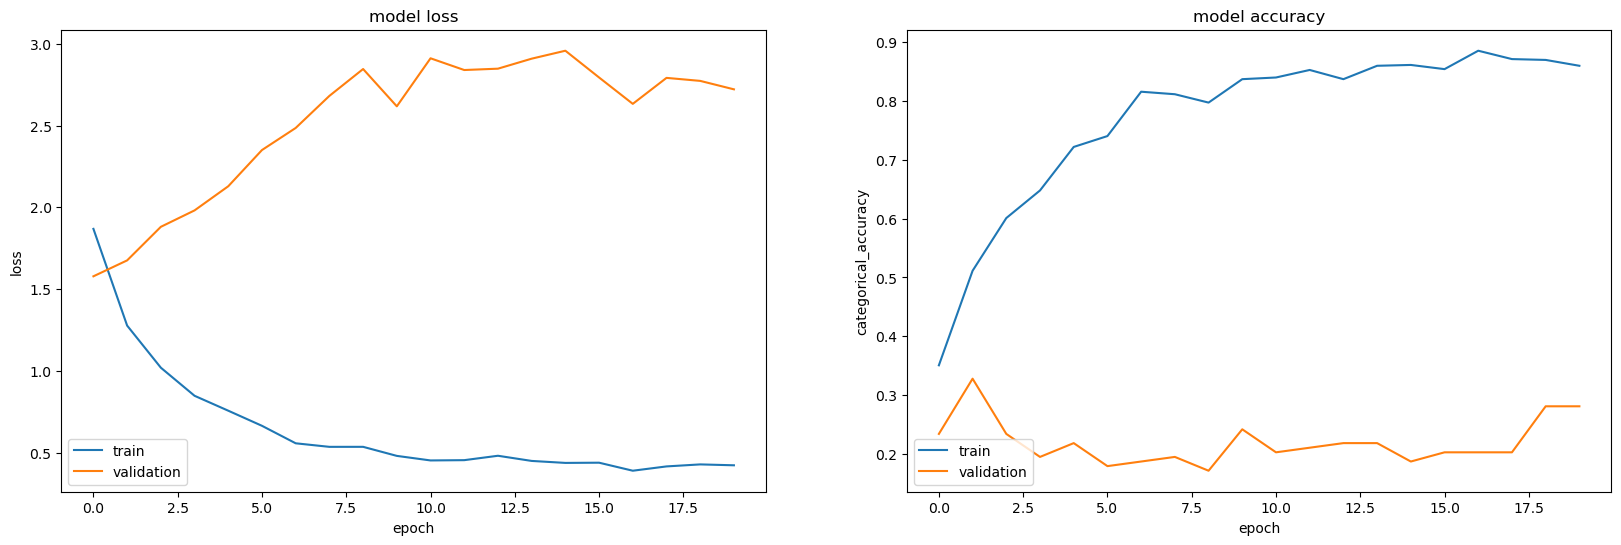

In [ ]:
plot(history)

# **MODEL 2**

In [ ]:
batch_size = 32
callbacks_list,steps_per_epoch, validation_steps = train_model()

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,dim_x,dim_y,img_idx)
val_generator = generator(val_path, val_doc, batch_size,dim_x,dim_y,img_idx)

In [ ]:
optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 13, 80, 80, 32)    2624      
                                                                 
 activation (Activation)     (None, 13, 80, 80, 32)    0         
                                                                 
 batch_normalization (BatchN  (None, 13, 80, 80, 32)   128       
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 6, 40, 40, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 6, 40, 40, 64)     16448     
                                                                 
 activation_1 (Activation)   (None, 6, 40, 40, 64)     0

In [ ]:
history2 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 0.5918 - categorical_accuracy: 0.7798Source path =  /kaggle/input/gesture-recognition/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2023-04-1610_05_15.639980/model-00001-0.59179-0.77976-2.24381-0.33594.h5
21/21 [==============================] - 82s 4s/step - loss: 0.5918 - categorical_accuracy: 0.7798 - val_loss: 2.2438 - val_categorical_accuracy: 0.3359 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.5349 - categorical_accuracy: 0.8125
Epoch 2: saving model to model_init_2023-04-1610_05_15.639980/model-00002-0.53487-0.81250-2.40027-0.37500.h5
21/21 [==============================] - 82s 4s/step - loss: 0.5349 - categorical_accuracy: 0.8125 - val_loss: 2.4003 - val_categorical_accuracy: 0.3750 - lr: 0.0100
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 

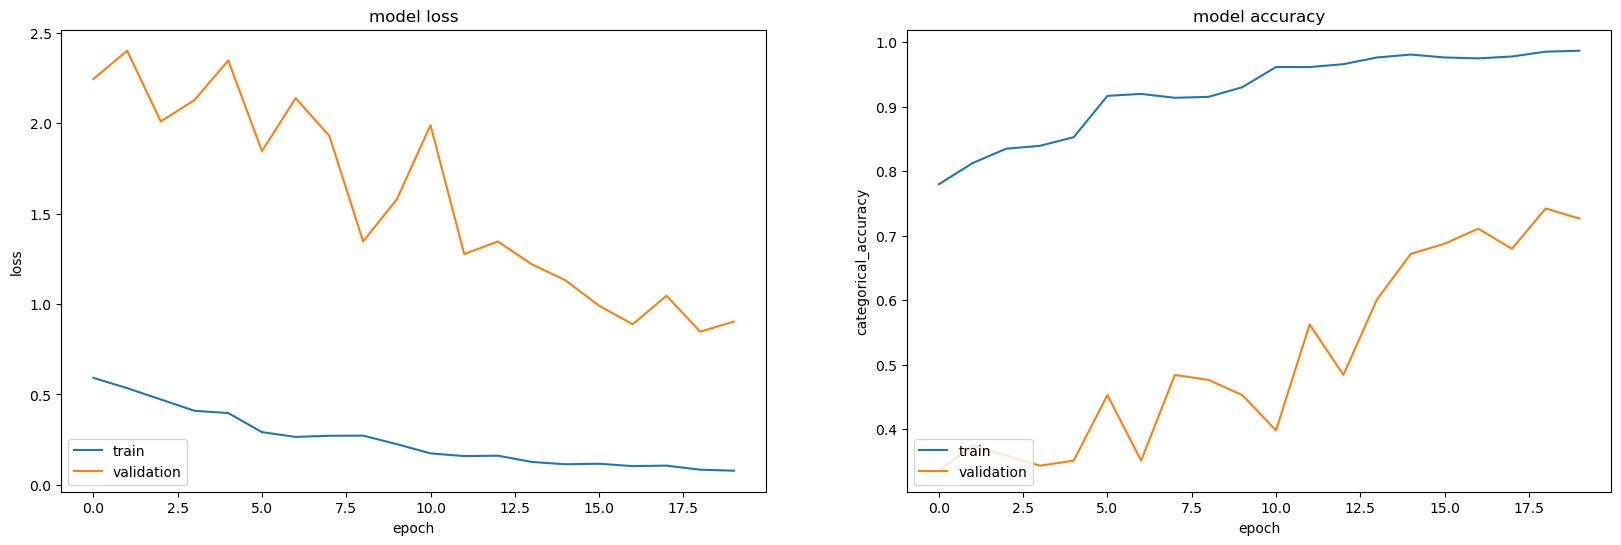

In [ ]:
plot(history2)

# **MODEL 3**

In [ ]:
batch_size = 32
dim_x = 100
dim_y = 100
img_idx = [2,4,6,8,10,12,14,16,18,20,22,24,26]

callbacks_list,steps_per_epoch, validation_steps = train_model()

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,dim_x,dim_y,img_idx)
val_generator = generator(val_path, val_doc, batch_size,dim_x,dim_y,img_idx)

In [ ]:
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(len(img_idx),dim_x,dim_y,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [ ]:
optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 13, 100, 100, 32)  2624      
                                                                 
 activation_3 (Activation)   (None, 13, 100, 100, 32)  0         
                                                                 
 batch_normalization_5 (Batc  (None, 13, 100, 100, 32)  128      
 hNormalization)                                                 
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 6, 50, 50, 32)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 6, 50, 50, 64)     16448     
                                                                 
 activation_4 (Activation)   (None, 6, 50, 50, 64)    

In [ ]:
history3 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6203 - categorical_accuracy: 0.4196Source path =  /kaggle/input/gesture-recognition/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2023-04-1610_05_15.639980/model-00001-1.62029-0.41964-1.56713-0.22656.h5
21/21 [==============================] - 88s 4s/step - loss: 1.6203 - categorical_accuracy: 0.4196 - val_loss: 1.5671 - val_categorical_accuracy: 0.2266 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.0753 - categorical_accuracy: 0.5893
Epoch 2: saving model to model_init_2023-04-1610_05_15.639980/model-00002-1.07530-0.58929-1.87394-0.17188.h5
21/21 [==============================] - 81s 4s/step - loss: 1.0753 - categorical_accuracy: 0.5893 - val_loss: 1.8739 - val_categorical_accuracy: 0.1719 - lr: 0.0100
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 

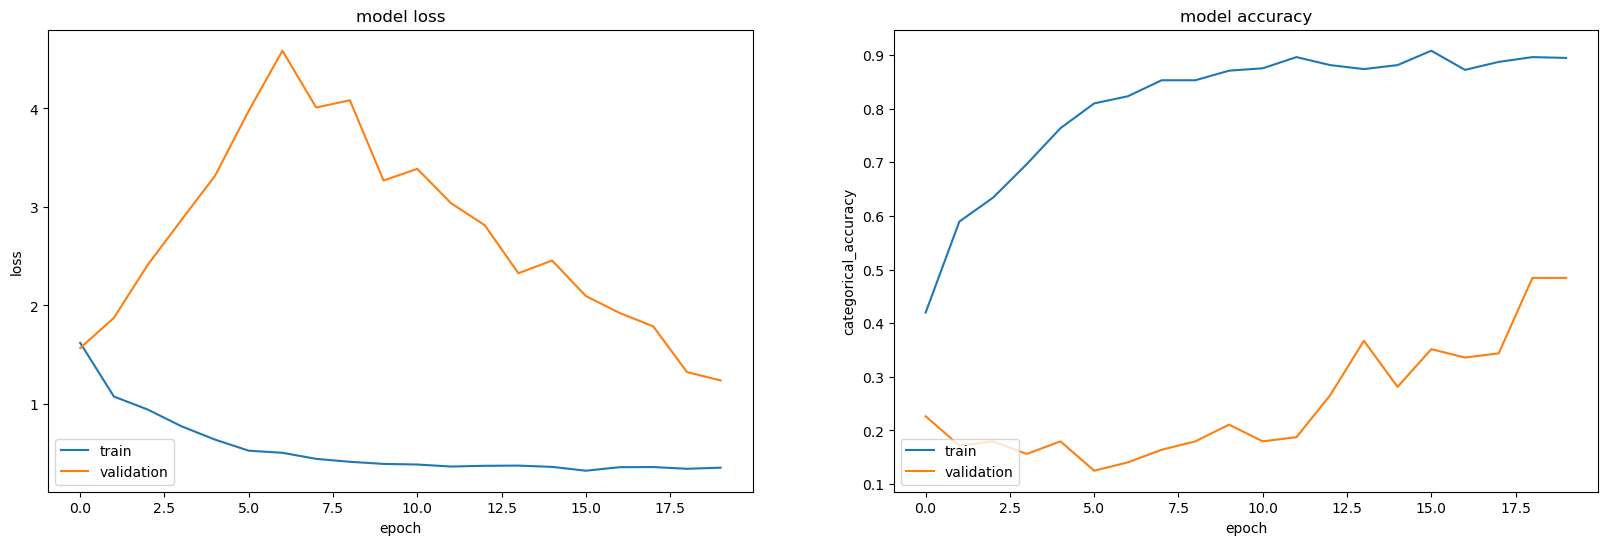

In [ ]:
plot(history3)

# **MODEL 4**

In [ ]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 13, 100, 100, 32)  2624      
                                                                 
 activation_3 (Activation)   (None, 13, 100, 100, 32)  0         
                                                                 
 batch_normalization_5 (Batc  (None, 13, 100, 100, 32)  128      
 hNormalization)                                                 
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 6, 50, 50, 32)    0         
 3D)                                                             
                                                                 
 conv3d_4 (Conv3D)           (None, 6, 50, 50, 64)     16448     
                                                                 
 activation_4 (Activation)   (None, 6, 50, 50, 64)    

In [ ]:
history4 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 0.9905 - categorical_accuracy: 0.6012
Epoch 1: saving model to model_init_2023-04-1610_05_15.639980/model-00001-0.99053-0.60119-2.69026-0.56250.h5
21/21 [==============================] - 86s 4s/step - loss: 0.9905 - categorical_accuracy: 0.6012 - val_loss: 2.6903 - val_categorical_accuracy: 0.5625 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 0.7630 - categorical_accuracy: 0.7202
Epoch 2: saving model to model_init_2023-04-1610_05_15.639980/model-00002-0.76301-0.72024-2.90805-0.39844.h5
21/21 [==============================] - 83s 4s/step - loss: 0.7630 - categorical_accuracy: 0.7202 - val_loss: 2.9080 - val_categorical_accuracy: 0.3984 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 0.5670 - categorical_accuracy: 0.7976
Epoch 3: saving model to model_init_2023-04-1610_05_15.639980/model-00003-0.56701-0.79762-1.67759-0.53125.h5
21/21 [================

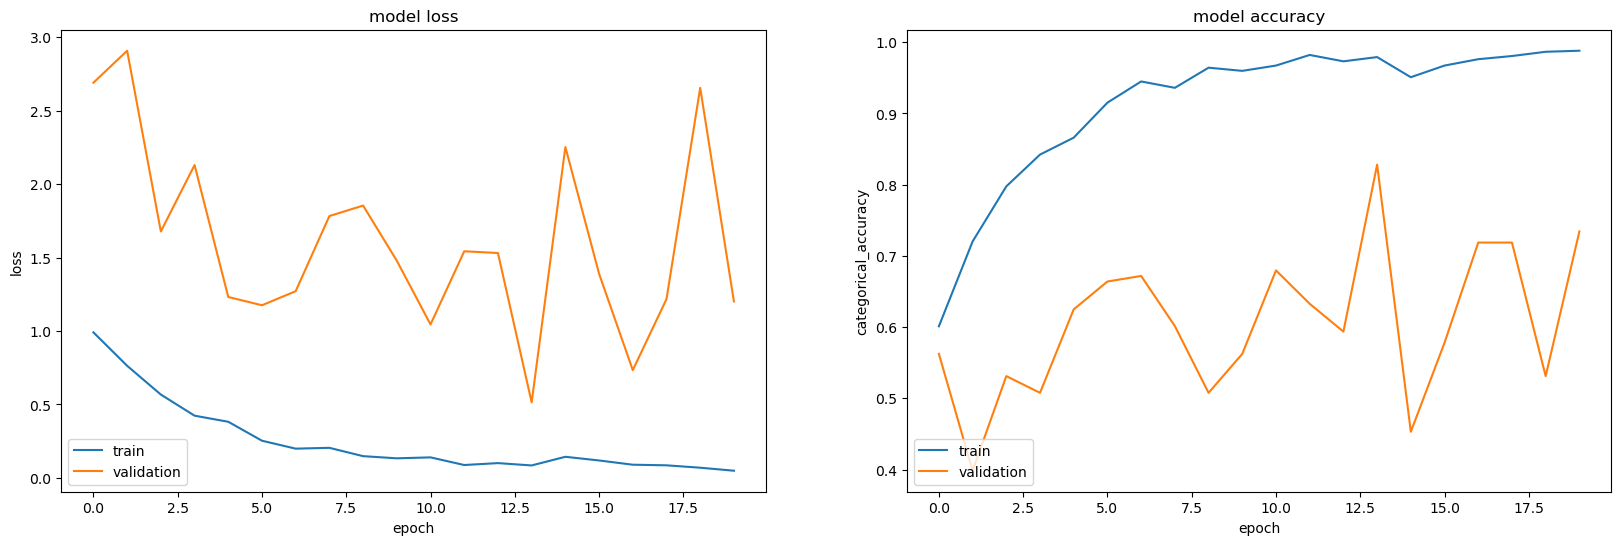

In [ ]:
plot(history4)

# **MODEL 5**

In [ ]:
batch_size = 32
dim_x = 80
dim_y = 80
img_idx = [i for i in range(7,27)]
callbacks_list,steps_per_epoch, validation_steps = train_model()

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,dim_x,dim_y,img_idx)
val_generator = generator(val_path, val_doc, batch_size,dim_x,dim_y,img_idx)

In [ ]:
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(len(img_idx),dim_x,dim_y,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [ ]:
optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 20, 80, 80, 32)    2624      
                                                                 
 activation_6 (Activation)   (None, 20, 80, 80, 32)    0         
                                                                 
 batch_normalization_10 (Bat  (None, 20, 80, 80, 32)   128       
 chNormalization)                                                
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 10, 40, 40, 32)   0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 10, 40, 40, 64)    16448     
                                                                 
 activation_7 (Activation)   (None, 10, 40, 40, 64)   

In [ ]:
history5 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition/Project_data/train ; batch size = 32
Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.6003 - categorical_accuracy: 0.3899Source path =  /kaggle/input/gesture-recognition/Project_data/val ; batch size = 32

Epoch 1: saving model to model_init_2023-04-1610_05_15.639980/model-00001-1.60027-0.38988-1.61117-0.21094.h5
21/21 [==============================] - 174s 9s/step - loss: 1.6003 - categorical_accuracy: 0.3899 - val_loss: 1.6112 - val_categorical_accuracy: 0.2109 - lr: 0.0100
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.0901 - categorical_accuracy: 0.5580
Epoch 2: saving model to model_init_2023-04-1610_05_15.639980/model-00002-1.09006-0.55804-2.35760-0.14062.h5
21/21 [==============================] - 130s 7s/step - loss: 1.0901 - categorical_accuracy: 0.5580 - val_loss: 2.3576 - val_categorical_accuracy: 0.1406 - lr: 0.0100
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss

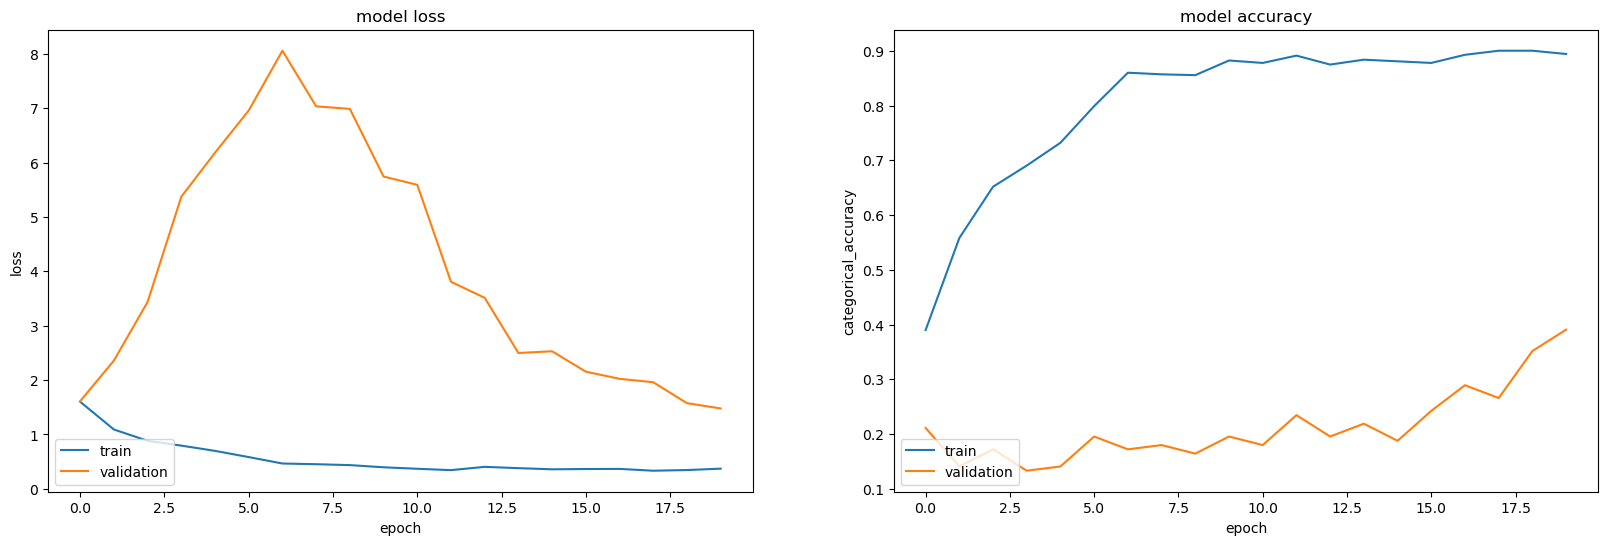

In [ ]:
plot(history5)

# **MODEL 6**

In [ ]:
batch_size = 20
dim_x = 80
dim_y = 80
img_idx = [2,4,6,8,10,12,14,16,18,20,22,24,26]
num_epochs = 25

callbacks_list,steps_per_epoch, validation_steps = train_model()

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,dim_x,dim_y,img_idx)
val_generator = generator(val_path, val_doc, batch_size,dim_x,dim_y,img_idx)

In [ ]:
model = Sequential()
model.add(Conv3D(32, (3, 3, 3), padding='same',
         input_shape=(len(img_idx),dim_x,dim_y,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [ ]:
optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_9 (Conv3D)           (None, 13, 80, 80, 32)    2624      
                                                                 
 activation_9 (Activation)   (None, 13, 80, 80, 32)    0         
                                                                 
 batch_normalization_15 (Bat  (None, 13, 80, 80, 32)   128       
 chNormalization)                                                
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 6, 40, 40, 32)    0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 6, 40, 40, 64)     16448     
                                                                 
 activation_10 (Activation)  (None, 6, 40, 40, 64)    

In [ ]:
history6 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.7678 - categorical_accuracy: 0.3471Source path =  /kaggle/input/gesture-recognition/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2023-04-1610_05_15.639980/model-00001-1.76785-0.34706-1.74509-0.17000.h5
34/34 [==============================] - 87s 3s/step - loss: 1.7678 - categorical_accuracy: 0.3471 - val_loss: 1.7451 - val_categorical_accuracy: 0.1700 - lr: 0.0100
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.2916 - categorical_accuracy: 0.4750
Epoch 2: saving model to model_init_2023-04-1610_05_15.639980/model-00002-1.29165-0.47500-2.02823-0.23000.h5
34/34 [==============================] - 83s 2s/step - loss: 1.2916 - categorical_accuracy: 0.4750 - val_loss: 2.0282 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 

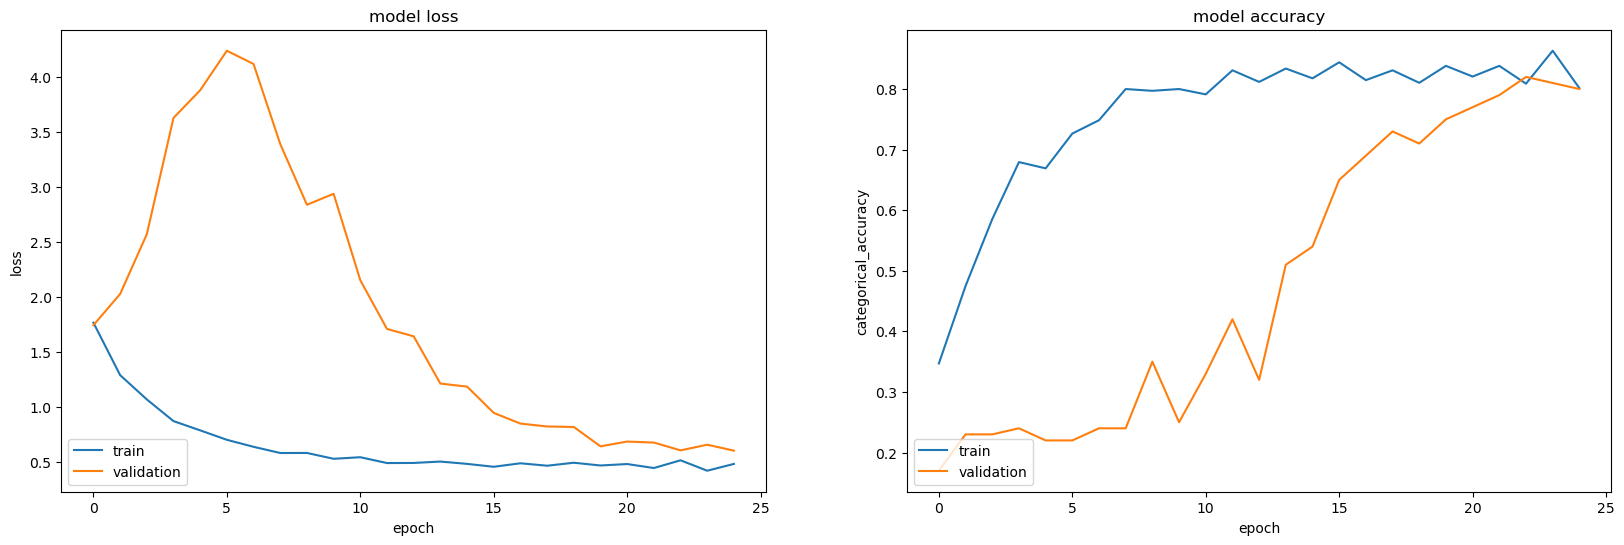

In [ ]:
plot(history6)

# **MODEL 7**

In [ ]:
batch_size = 20
dim_x = 80
dim_y = 80
img_idx = [2,4,6,8,10,12,14,16,18,20,22,24,26]
num_epochs = 25

callbacks_list,steps_per_epoch, validation_steps = train_model()

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,dim_x,dim_y,img_idx)
val_generator = generator(val_path, val_doc, batch_size,dim_x,dim_y,img_idx)

In [ ]:
#New Model 2
model = Sequential()
model.add(Conv3D(16, (3, 3, 3), padding='same',input_shape=(len(img_idx),dim_x,dim_y,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(32, (3, 3, 3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(128, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Dense(5,activation='softmax'))

In [ ]:
optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_12 (Conv3D)          (None, 13, 80, 80, 16)    1312      
                                                                 
 activation_12 (Activation)  (None, 13, 80, 80, 16)    0         
                                                                 
 batch_normalization_20 (Bat  (None, 13, 80, 80, 16)   64        
 chNormalization)                                                
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 6, 40, 40, 16)    0         
 g3D)                                                            
                                                                 
 conv3d_13 (Conv3D)          (None, 6, 40, 40, 32)     13856     
                                                                 
 activation_13 (Activation)  (None, 6, 40, 40, 32)    

In [ ]:
history7 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.7036 - categorical_accuracy: 0.3412Source path =  /kaggle/input/gesture-recognition/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2023-04-1610_05_15.639980/model-00001-1.70362-0.34118-1.67265-0.18000.h5
34/34 [==============================] - 76s 2s/step - loss: 1.7036 - categorical_accuracy: 0.3412 - val_loss: 1.6726 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.3227 - categorical_accuracy: 0.4853
Epoch 2: saving model to model_init_2023-04-1610_05_15.639980/model-00002-1.32273-0.48529-1.71368-0.33000.h5
34/34 [==============================] - 72s 2s/step - loss: 1.3227 - categorical_accuracy: 0.4853 - val_loss: 1.7137 - val_categorical_accuracy: 0.3300 - lr: 0.0100
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 

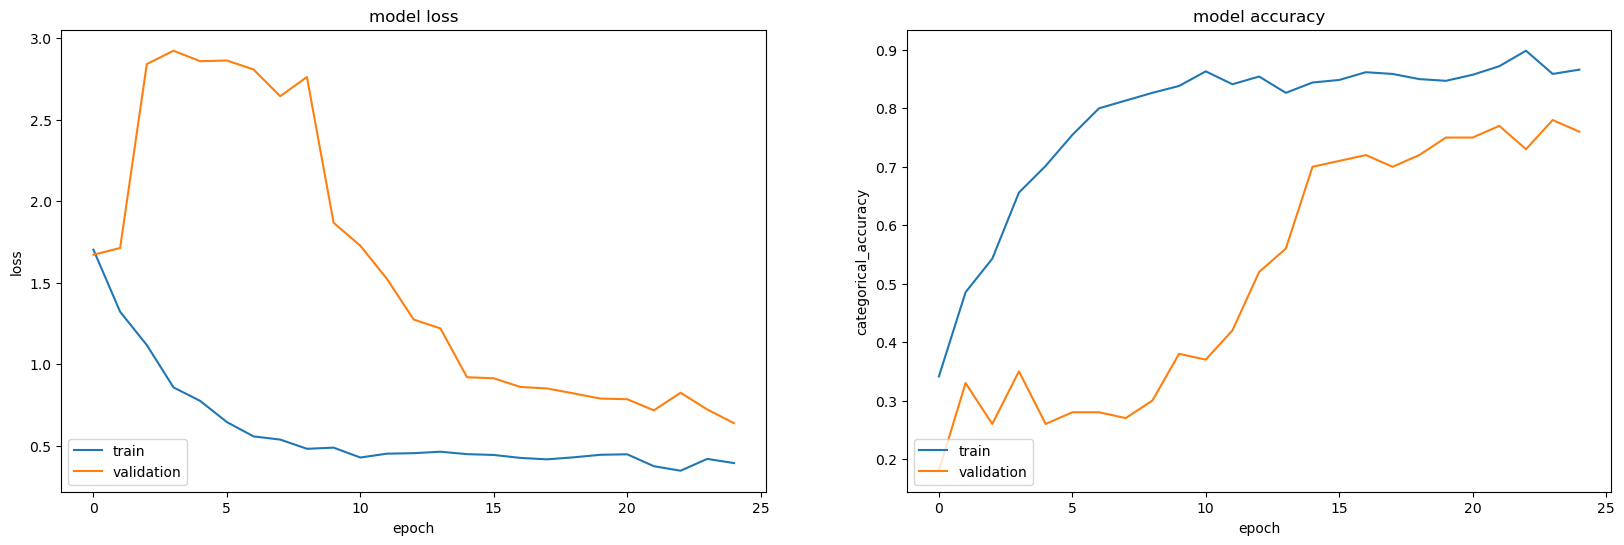

In [ ]:
plot(history7)

# **MODEL 8**

In [ ]:
batch_size = 20
dim_x = 80
dim_y = 80
img_idx = [2,4,6,8,10,12,14,16,18,20,22,24,26]
num_epochs = 25

callbacks_list,steps_per_epoch, validation_steps = train_model()

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,dim_x,dim_y,img_idx)
val_generator = generator(val_path, val_doc, batch_size,dim_x,dim_y,img_idx)

In [ ]:
#New Model 3
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',
         input_shape=(len(img_idx),dim_x,dim_y,3), activation = 'relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(64, (2, 2), padding='same', activation = 'relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(128, (2, 2), padding='same', activation = 'relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(GRU(128))
model.add(Dropout(0.5)),

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [ ]:
optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [ ]:
history8 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.7433 - categorical_accuracy: 0.2750Source path =  /kaggle/input/gesture-recognition/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2023-04-1610_05_15.639980/model-00001-1.74330-0.27500-1.63986-0.29000.h5
34/34 [==============================] - 78s 2s/step - loss: 1.7433 - categorical_accuracy: 0.2750 - val_loss: 1.6399 - val_categorical_accuracy: 0.2900 - lr: 0.0100
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.4768 - categorical_accuracy: 0.3588
Epoch 2: saving model to model_init_2023-04-1610_05_15.639980/model-00002-1.47680-0.35882-2.03829-0.21000.h5
34/34 [==============================] - 81s 2s/step - loss: 1.4768 - categorical_accuracy: 0.3588 - val_loss: 2.0383 - val_categorical_accuracy: 0.2100 - lr: 0.0100
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 

In [ ]:
print (model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, None, None,  896      
 ibuted)                      32)                                
                                                                 
 time_distributed_1 (TimeDis  (None, None, None, None,  128      
 tributed)                    32)                                
                                                                 
 time_distributed_2 (TimeDis  (None, None, None, None,  0        
 tributed)                    32)                                
                                                                 
 time_distributed_3 (TimeDis  (None, None, None, None,  8256     
 tributed)                    64)                                
                                                                 
 time_distributed_4 (TimeDis  (None, None, None, None,

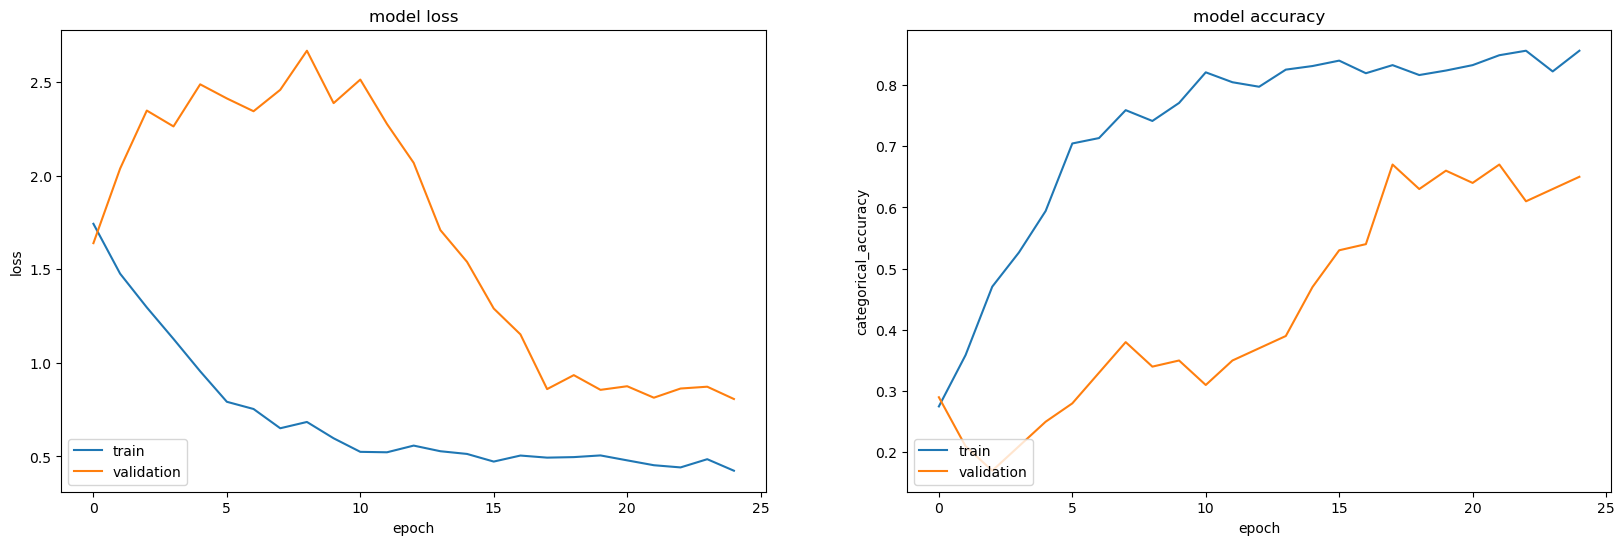

In [ ]:
plot(history8)

# **MODEL 9**

In [ ]:
batch_size = 20
dim_x = 100
dim_y = 100
img_idx = [2,4,6,8,10,12,14,16,18,20,22,24,26]
num_epochs = 25

callbacks_list,steps_per_epoch, validation_steps = train_model()

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,dim_x,dim_y,img_idx)
val_generator = generator(val_path, val_doc, batch_size,dim_x,dim_y,img_idx)

In [ ]:
#New Model 3
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',
         input_shape=(len(img_idx),dim_x,dim_y,3), activation = 'relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(64, (2, 2), padding='same', activation = 'relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(128, (2, 2), padding='same', activation = 'relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(GRU(128))
model.add(Dropout(0.5)),

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [ ]:
optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [ ]:
history9 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.7224 - categorical_accuracy: 0.2691Source path =  /kaggle/input/gesture-recognition/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2023-04-1610_05_15.639980/model-00001-1.72240-0.26912-1.61735-0.27000.h5
34/34 [==============================] - 82s 2s/step - loss: 1.7224 - categorical_accuracy: 0.2691 - val_loss: 1.6173 - val_categorical_accuracy: 0.2700 - lr: 0.0100
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.3043 - categorical_accuracy: 0.4574
Epoch 2: saving model to model_init_2023-04-1610_05_15.639980/model-00002-1.30429-0.45735-1.89652-0.23000.h5
34/34 [==============================] - 77s 2s/step - loss: 1.3043 - categorical_accuracy: 0.4574 - val_loss: 1.8965 - val_categorical_accuracy: 0.2300 - lr: 0.0100
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 

In [ ]:
print (model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_10 (TimeDi  (None, None, None, None,  896      
 stributed)                   32)                                
                                                                 
 time_distributed_11 (TimeDi  (None, None, None, None,  128      
 stributed)                   32)                                
                                                                 
 time_distributed_12 (TimeDi  (None, None, None, None,  0        
 stributed)                   32)                                
                                                                 
 time_distributed_13 (TimeDi  (None, None, None, None,  8256     
 stributed)                   64)                                
                                                                 
 time_distributed_14 (TimeDi  (None, None, None, None,

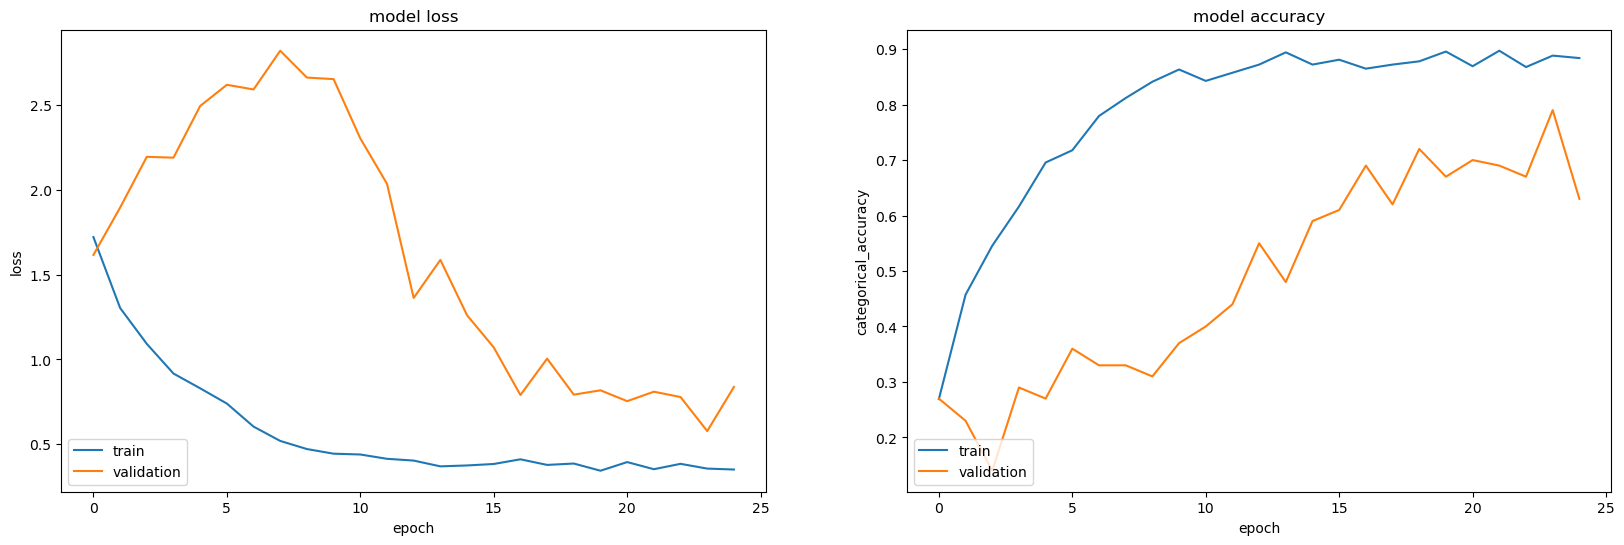

In [ ]:
plot(history9)

# **MODEL 10**

In [ ]:
batch_size = 20
dim_x = 80
dim_y = 80
img_idx = [2,4,6,8,10,12,14,16,18,20,22,24,26]
num_epochs = 25

callbacks_list,steps_per_epoch, validation_steps = train_model()

In [ ]:
train_generator = generator(train_path, train_doc, batch_size,dim_x,dim_y,img_idx)
val_generator = generator(val_path, val_doc, batch_size,dim_x,dim_y,img_idx)

In [ ]:
#New Model 4
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',
         input_shape=(len(img_idx),dim_x,dim_y,3), activation = 'relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(64, (2, 2), padding='same', activation = 'relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(128, (2, 2), padding='same', activation = 'relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Conv2D(256, (2, 2), padding='same', activation = 'relu')))
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))

model.add(TimeDistributed(Flatten()))
model.add(GRU(128))
model.add(Dropout(0.5)),

model.add(Dense(64,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [ ]:
optimiser = 'sgd'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])


In [ ]:
history10 = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /kaggle/input/gesture-recognition/Project_data/train ; batch size = 20
Epoch 1/25
34/34 [==============================] - ETA: 0s - loss: 1.7332 - categorical_accuracy: 0.2765Source path =  /kaggle/input/gesture-recognition/Project_data/val ; batch size = 20

Epoch 1: saving model to model_init_2023-04-1610_05_15.639980/model-00001-1.73321-0.27647-1.75974-0.16000.h5
34/34 [==============================] - 78s 2s/step - loss: 1.7332 - categorical_accuracy: 0.2765 - val_loss: 1.7597 - val_categorical_accuracy: 0.1600 - lr: 0.0100
Epoch 2/25
34/34 [==============================] - ETA: 0s - loss: 1.4029 - categorical_accuracy: 0.4118
Epoch 2: saving model to model_init_2023-04-1610_05_15.639980/model-00002-1.40293-0.41176-2.08559-0.19000.h5
34/34 [==============================] - 73s 2s/step - loss: 1.4029 - categorical_accuracy: 0.4118 - val_loss: 2.0856 - val_categorical_accuracy: 0.1900 - lr: 0.0100
Epoch 3/25
34/34 [==============================] - ETA: 0s - loss: 

In [ ]:
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_20 (TimeDi  (None, None, None, None,  896      
 stributed)                   32)                                
                                                                 
 time_distributed_21 (TimeDi  (None, None, None, None,  128      
 stributed)                   32)                                
                                                                 
 time_distributed_22 (TimeDi  (None, None, None, None,  0        
 stributed)                   32)                                
                                                                 
 time_distributed_23 (TimeDi  (None, None, None, None,  8256     
 stributed)                   64)                                
                                                                 
 time_distributed_24 (TimeDi  (None, None, None, None,

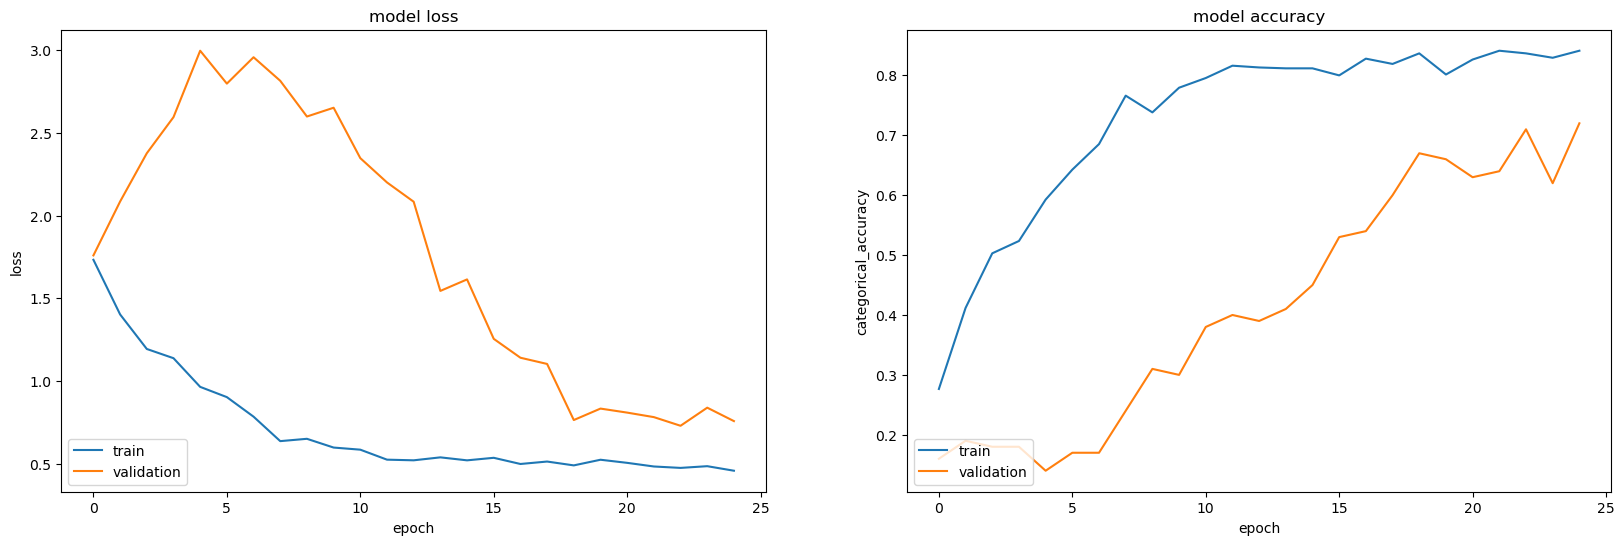

In [ ]:
plot(history10)

**MODEL 6 is the final model with best accuracies obtained at epoch 23.**<br>
**Training accuracy – 80%, Val accuracy – 82%.**<br>
**This model uses the least number of parameters too.**